In [1]:
#####--------------------------------------------------------------------#####
##### PREPARATION
#####--------------------------------------------------------------------#####
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from typing import List, Union, Optional, Callable
import pickle
from Bio import AlignIO, SeqIO
from ete3 import Tree, TreeNode
from gctree import CollapsedTree

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from ete3 import Tree, faces, TreeStyle, NodeStyle, TextFace, SequenceFace, COLOR_SCHEMES, CircleFace
from GCTree_preparation import *
import warnings
import math
from matplotlib.patches import Rectangle
warnings.filterwarnings("ignore")

path_to_storage = "/media/hieunguyen/HNHD01/storage/all_BSimons_datasets"
outdir = "/media/hieunguyen/GSHD_HN01/outdir/sc_bulk_BCR_data_analysis_v0.1"

PROJECT = "220701_etc_biopsies"
path_to_main_output = f"{outdir}/tree_analysis/{PROJECT}"
path_to_01_output = os.path.join(path_to_main_output, "01_output")
path_to_08_output = os.path.join(path_to_main_output, "08_output")
os.system(f"mkdir -p {path_to_08_output}")

output_type = "mouse_based_output"

path_to_trees = os.path.join(path_to_storage, PROJECT, "GCtrees/v0.2", output_type)

all_tree_folder = [item for item in pathlib.Path(path_to_trees).glob("*") if 
                   os.path.isfile(f"{str(item)}/02_dnapars/gctree.out.inference.1.nk") == True]

all_nk_files = [item for item in pathlib.Path(path_to_trees).glob("*/*/*gctree.out.inference.1.nk")]  
print(f"Number of trees: {len(all_tree_folder)}")   

path_to_metadata = "/media/hieunguyen/HNSD01/src/sc_bulk_BCR_data_analysis/preprocessing/220701_etc_biopsies/metadata.csv"
mid_metadata = pd.read_csv(path_to_metadata, sep =";")
mid_metadata = mid_metadata.drop(['Unnamed: 6', 'Unnamed: 7'], axis = 1)
mid_metadata.columns = ['MID', 'mouse', 'age', 'day', 'population', 'label', 'hex color']

##### Re run the summary analysis of all trees and rendering tree figures
# rerun = True
rerun = False

path_to_04_output = os.path.join(outdir, "VDJ_output", "04_output")
thres = 0.85

clonedf = pd.read_csv(os.path.join(path_to_04_output, "full_clonedf_with_mutation_rate.csv"), index_col= [0])
clonedf = clonedf[clonedf['num_mutation'] != "region_not_covered-skip"]
clonedf = clonedf[clonedf['dataset.name'] == "220701_etc_biopsies"]

maindf = pd.read_csv(f"{path_to_01_output}/tree_summarydf.csv")

def get_tree_sum_abundance(x):
    mouseid = x.split("_")[0]
    path_to_save_tree_svg = os.path.join(path_to_01_output, mouseid)
    os.system(f"mkdir -p {path_to_save_tree_svg}")

    treeobj = saveTreeobj[x] 

    idmapdf = treeobj.idmapseqdf.copy()
    seqdf = treeobj.seqdf.copy()
    seqdf["population"] = seqdf["MID"].apply(lambda x: mid_metadata[mid_metadata["MID"] == x]["population"].values[0])
    seqdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")
    abd = seqdf.abundance.sum()
    return abd

tqdm.pandas()
# Reload the dictionary from the pickle file
with open(f"{path_to_01_output}/saveTreeobj.pkl", "rb") as f:
    saveTreeobj = pickle.load(f)
if os.path.isfile(f"{path_to_01_output}/tree_summarydf.addedAbundance.csv") == False:
    maindf["clone_sum_abundance"] = maindf["cloneid"].progress_apply(lambda x: get_tree_sum_abundance(x))
    maindf["pct_sum_abundance"] = maindf[["clone_sum_abundance", "mouseID"]].progress_apply(lambda x: x[0]/maindf[maindf["mouseID"] == x[1]]["clone_sum_abundance"].sum(), axis = 1)
    maindf = maindf.sort_values(by=  "pct_sum_abundance", ascending = False)
    maindf.to_csv(f"{path_to_01_output}/tree_summarydf.addedAbundance.csv", index=False)
else:
    maindf = pd.read_csv(f"{path_to_01_output}/tree_summarydf.addedAbundance.csv")
color_path = "./hex_color.csv"

/home/hieunguyen/miniconda3/envs/ete3_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of trees: 7618


In [2]:
# ##### analysis example for 1 tree. 
# cloneid = "m30_IGHV1-82-01_IGHJ2-01_30_1.aln"

# mouseid = cloneid.split("_")[0]
# path_to_save_tree_svg = os.path.join(path_to_01_output, mouseid)
# os.system(f"mkdir -p {path_to_save_tree_svg}")

# treeobj = saveTreeobj[cloneid] 
# avai_mids = treeobj.seqdf["MID"].unique()
# mid_color_pal = pd.read_csv(color_path, index_col = [0]).to_dict()["hex color"]

# ts = treeobj.generate_tree_style(color_path = color_path)
# # treeobj.tree.render("%%inline", tree_style=ts) 

# for input_mid in avai_mids:
#     if input_mid == "GL":
#         input_mid_col = "gray"
#     else:
#         input_mid_col = mid_color_pal[input_mid]
#     ts.legend.add_face(CircleFace(10, input_mid_col), column = 0)
#     ts.legend.add_face(TextFace(input_mid), column = 0)

# idmapdf = treeobj.idmapseqdf.copy()
# seqdf = treeobj.seqdf.copy()
# seqdf["population"] = seqdf["MID"].apply(lambda x: mid_metadata[mid_metadata["Unnamed: 0"] == x]["population"].values[0])
# seqdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")
# treeobj.tree.render(f"%%inline", tree_style=ts) 


In [3]:
#####-------------------------------------------------------------#####
##### Generate nodedf: summary all features of nodes
#####-------------------------------------------------------------#####
if os.path.isfile(os.path.join(path_to_08_output, "nodedf.csv")) == False:
    nodedf = pd.DataFrame()
    for cloneid in tqdm(saveTreeobj.keys()):
        mouseid = cloneid.split("_")[0]
        path_to_save_tree_svg = os.path.join(path_to_01_output, mouseid)
        os.system(f"mkdir -p {path_to_save_tree_svg}")

        treeobj = saveTreeobj[cloneid] 

        idmapdf = treeobj.idmapseqdf.copy()
        seqdf = treeobj.seqdf.copy()
        seqdf["population"] = seqdf["MID"].apply(lambda x: mid_metadata[mid_metadata["MID"] == x]["population"].values[0])
        seqdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")

        df = pd.DataFrame(data = seqdf.seqid.unique(), columns = ["seqid"])
        df["mouseid"] = mouseid
        df["cloneID"] = cloneid
        df["population"] = df["seqid"].apply(lambda x: ",".join(seqdf[seqdf["seqid"] == x]["population"].values) 
                                            if len(seqdf[seqdf["seqid"] == x]["population"].unique()) > 1 else seqdf[seqdf["seqid"] == x]["population"].values[0])
        df["MID"] = df["seqid"].apply(lambda x: ",".join(seqdf[seqdf["seqid"] == x]["MID"].values) 
                                            if len(seqdf[seqdf["seqid"] == x]["MID"].unique()) > 1 else seqdf[seqdf["seqid"] == x]["MID"].values[0])
        df["mixed_node"] = df["population"].apply(lambda x: "yes" if "," in x else "no")

        df["dist_to_root"] = df["seqid"].apply(lambda x: treeobj.node_depth(node = [item for item in treeobj.nodes if item.name == x][0], topo = False))
        df["topo_dist_to_root"] = df["seqid"].apply(lambda x: treeobj.node_depth(node = [item for item in treeobj.nodes if item.name == x][0], topo = True))

        deepest_node = df[df["dist_to_root"] == df["dist_to_root"].max()].seqid.unique()[0]

        df["dist_to_deepest"] = df["seqid"].apply(lambda x: treeobj.tree.get_distance(x, deepest_node) if x != deepest_node else 0)
        df["topo_dist_to_deepest"] = df["seqid"].apply(lambda x: treeobj.tree.get_distance(x, deepest_node, topology_only= True) if x != deepest_node else 0)

        # heatmap_plotdf = df[["seqid",'population', "mixed_node", 'dist_to_root', 'dist_to_deepest']]
        # heatmap_plotdf["population"] = heatmap_plotdf[["population", "mixed_node", "seqid"]].apply(lambda x: "_".join(x), axis = 1)
        # heatmap_plotdf = heatmap_plotdf.drop(["mixed_node", "seqid"], axis = 1).set_index("population")
        # plt.figure(figsize= (10, 15))
        # sns.heatmap(heatmap_plotdf, cmap="coolwarm", cbar=-1, linewidths=0.5, linecolor='black')
        # for tick_label in plt.gca().get_yticklabels():
        #     tick_text = tick_label.get_text()
        #     if "yes" in tick_text:
        #         tick_label.set_color('red')
        #     elif "biopsy" in tick_text:
        #         tick_label.set_color('blue')
        #     else:
        #         tick_label.set_color('black')
                
        df["population2"] = df["population"].apply(lambda x: "biopsy" if x == "biopsy" else "other")
        min_val = dict()
        max_val = dict()
        mean_val = dict()

        for dist_type in ["dist_to_root", "dist_to_deepest"]:
            min_val[dist_type] = dict()
            max_val[dist_type] = dict()
            mean_val[dist_type] = dict()
            for group in df.population2.unique():
                min_val[dist_type][group] = df.groupby("population2")[dist_type].min()[group]
                max_val[dist_type][group] = df.groupby("population2")[dist_type].max()[group]
                mean_val[dist_type][group] = df.groupby("population2")[dist_type].mean()[group]
        df["parent_node"] = df["seqid"].apply(lambda x: treeobj.tree.search_nodes(name=x)[0].up.name)

        df["parent_node_type"] = df["parent_node"].apply(lambda x: seqdf[seqdf["seqid"] == x]["population"].values[0] if x in seqdf["seqid"].values else "inferred_node")
        nodedf = pd.concat([nodedf, df], axis = 0)
    nodedf.to_csv(os.path.join(path_to_08_output, "nodedf.csv"), index = False)
else:
    nodedf = pd.read_csv(os.path.join(path_to_08_output, "nodedf.csv"))

<Axes: xlabel='dist_to_root', ylabel='dist_to_deepest'>

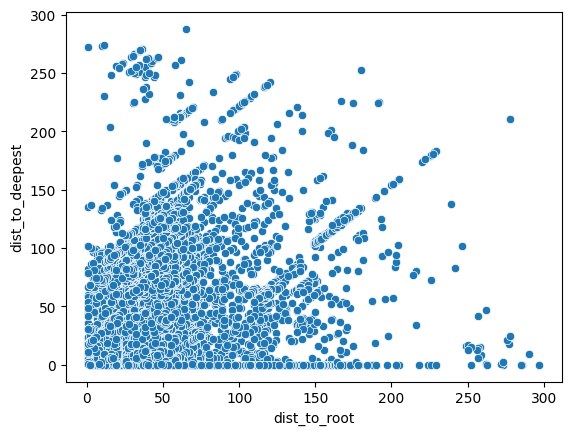

In [5]:
sns.scatterplot(data = nodedf, x = "dist_to_root", y = "dist_to_deepest")